In [1]:
from xvfbwrapper import Xvfb

#vdisplay = Xvfb()
#vdisplay.start()

# for environ
import os

# only using device 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

# importing tensorflow
import tensorflow as tf

# import scipy
import scipy, csv

import pandas as pd

In [ ]:
import gym
from gym import wrappers
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

# to display environment data
# see https://gist.github.com/thomelane/79e97630ba46c45985a946cae4805885
from IPython import display

In [3]:
import sys
sys.path += ['/localhome/volodin/local/usr/bin']
sys.path

['',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python36.zip',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/lib-dynload',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/IPython/extensions',
 '/localhome/volodin/.ipython',
 '/localhome/volodin/local/usr/bin']

In [4]:
from xvfbwrapper import Xvfb

vdisplay = Xvfb()
vdisplay.start()

OSError: Can not find Xvfb. Please install it and try again.

In [3]:
tf.reset_default_graph()
# allowing GPU memory growth to allocate only what we need
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
sess = tf.Session(config=config, graph = tf.get_default_graph())

In [4]:
env = gym.make('CartPole-v0')
#env = wrappers.Monitor(env, 'video')
env.reset()

array([0.00254163, 0.04386239, 0.02868513, 0.01695128])

In [5]:
env.action_space

Discrete(2)

In [6]:
S_DIM = 4
ACTIONS = 2

In [7]:
# states
states = tf.placeholder(tf.float64, shape = (None, S_DIM,))

# taken actions
actions = tf.placeholder(tf.int64, shape = (None,))

# rewards obtained
rewards = tf.placeholder(tf.float64, shape = (None,))

def fc_layer(x, n, activation = tf.nn.sigmoid):
    """ Fully connected layer for input x and output dim n """
    return tf.contrib.layers.fully_connected(x, n, activation_fn=activation,
    weights_initializer=tf.initializers.lecun_normal(), weights_regularizer=None,
    biases_initializer=tf.zeros_initializer(), biases_regularizer=None, trainable=True)

In [8]:
# layers
with tf.name_scope('layers'):
    z = states # state is an input
    z = fc_layer(z, 10)
    z = fc_layer(z, 10)
    z = fc_layer(z, 10)
    z = fc_layer(z, ACTIONS, activation = None)
    output = z

In [9]:
# softmax to make probability distribution
logits = tf.nn.softmax(output)

# predicted labels
labels = tf.argmax(logits, axis = 1)

In [10]:
params = tf.trainable_variables()

In [11]:
# one-hot encoded actions
a_one_hot = tf.one_hot(actions, ACTIONS)

# taken logits
#logits_taken = tf.gather(logits, actions, axis = 1)
logits_taken = tf.boolean_mask(logits, a_one_hot)

# logarithm
log_logits = tf.log(logits_taken)

# logarithm of logits * reward
r_log_logits_sum = tf.reduce_sum(tf.multiply(rewards, log_logits))

# calculated loss
loss = -tf.reduce_sum(tf.multiply(log_logits, tf.cumsum(rewards, reverse = True)))
#loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(a_one_hot, logits)) * tf.reduce_sum(rewards)

# derivarive w.r.t. params
grads = tf.gradients(r_log_logits_sum, params)

/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [12]:
grads

[<tf.Tensor 'gradients/layers/fully_connected/MatMul_grad/MatMul_1:0' shape=(4, 10) dtype=float64>,
 <tf.Tensor 'gradients/layers/fully_connected/BiasAdd_grad/BiasAddGrad:0' shape=(10,) dtype=float64>,
 <tf.Tensor 'gradients/layers/fully_connected_1/MatMul_grad/MatMul_1:0' shape=(10, 10) dtype=float64>,
 <tf.Tensor 'gradients/layers/fully_connected_1/BiasAdd_grad/BiasAddGrad:0' shape=(10,) dtype=float64>,
 <tf.Tensor 'gradients/layers/fully_connected_2/MatMul_grad/MatMul_1:0' shape=(10, 10) dtype=float64>,
 <tf.Tensor 'gradients/layers/fully_connected_2/BiasAdd_grad/BiasAddGrad:0' shape=(10,) dtype=float64>,
 <tf.Tensor 'gradients/layers/fully_connected_3/MatMul_grad/MatMul_1:0' shape=(10, 2) dtype=float64>,
 <tf.Tensor 'gradients/layers/fully_connected_3/BiasAdd_grad/BiasAddGrad:0' shape=(2,) dtype=float64>]

In [13]:
def sample_action(observation):
    """ Sample an action from the policy """
    
    if np.random.random() <= eps:
        return env.action_space.sample()
    
    p = sess.run(logits, feed_dict = {states: [observation]})[0]
    return np.random.choice(range(2), p = p)

In [14]:
def get_rollout():
    """ Obtain rollout using policy """
    done = False
    observation = env.reset()
    sar = []
    while not done:
        act = sample_action(observation)
        observation_, reward, done, info = env.step(act) # take a random action
        sar.append((observation, act, reward))
        observation = observation_
    env.close()
    return sar

In [15]:
# learning rate for policy gradients
gamma = tf.placeholder(tf.float64, shape = ())

In [16]:
def learning_step():
    """ Gradient descent step """
    return tf.group([p.assign(tf.add(p, tf.multiply(gamma, g))) for p, g in zip(params, grads)])

In [28]:
opt = tf.train.AdamOptimizer(0.01).minimize(loss)

In [29]:
# one learning iteration
#step = learning_step()
step = opt

In [30]:
def train_step(gamma_):
    # obtaining rollout data
    S, A, R = list(zip(*get_rollout()))
    sess.run(step, feed_dict = {states: S, actions: A, rewards: R, gamma: gamma_})
    return np.sum(R)

In [31]:
init = tf.global_variables_initializer()
sess.run(init)
r = []

In [37]:
# non-greediness
eps = 0

In [33]:
for i in tqdm(range(1000)):
    #gamma_ = (1000 - i) / 50000.
    gamma_ = 0.05
    r += [train_step(gamma_)]

100%|██████████| 1000/1000 [00:22<00:00, 16.90it/s]


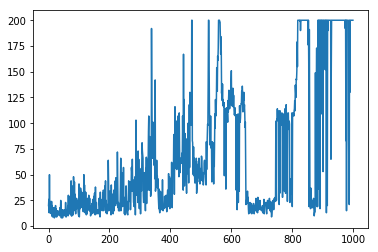

In [35]:
plt.plot(pd.DataFrame(r).rolling(1).median())

In [45]:
len(get_rollout())

200